# 1_SPHEREx_LVF

# Build SPHEREx LVF Design

## Authors
- Yujin Yang, Woong-Seob Jeong (KASI SPHEREx Team)

## Goal
- Understand various photometric systems & filter transmission (broadband, narrowband)
- Understand linear variable filter
- Simulate LVF transmission
- Simulate SPHEREx wavelength map

## Recap: SPHEREx LVF definition

In [1]:
# TODO: Include SPHEREx LVF specification here (image & table)

## Setting for this notebook

In [7]:
# Setting for Jupyter notebook environment
# Display full output in Jupyter, not only last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"   # last or last_expr

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

# Do not truncate outputs
np.set_printoptions(threshold=np.inf)

# Set default resolution for plots
mpl.rcParams["figure.dpi"] = 150

## 1. Filter Transmission Curves

### Broadband filters
* Examples for photometric system
    - Johnson, JHK, WISE, PanSTARRS, Subaru, Gaia DR2 
    - [Link of Spectlite package](https://speclite.readthedocs.io/en/latest/filters.html)
    - SDSS (https://www.astroml.org/_images/plot_sdss_filters_1.png)
    
![astroML plot](https://www.astroml.org/_images/plot_sdss_filters_1.png)

### Narrowband filters
- An example transmission curve for a narrowband filter

Text(0.5, 1.0, 'DECam N419 narrowband filter')

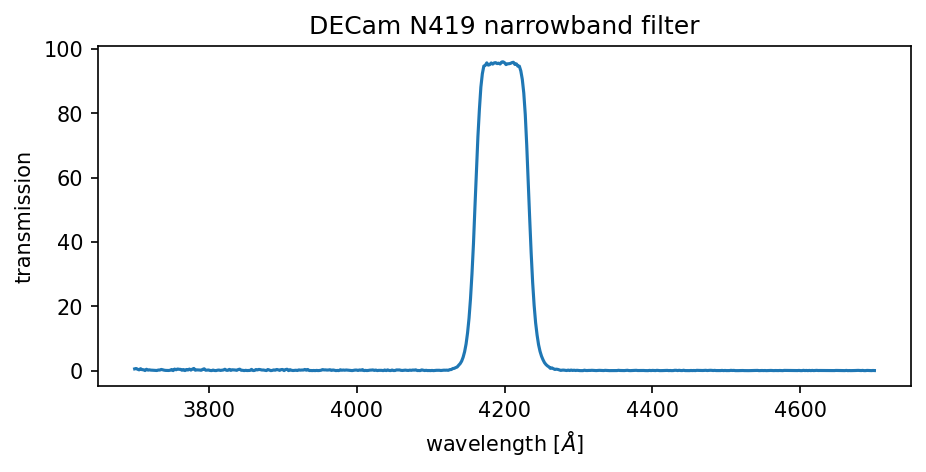

In [8]:
T = Table.read('data/transmission_n419.csv')

plt.figure(figsize=(7,3))
plt.plot(T['Wavelength']*10, T['trans'])
plt.xlabel('wavelength [$\AA$]')
plt.ylabel('transmission')
plt.title('DECam N419 narrowband filter')

### Gaussian Approximation for narrowband filters

Text(0, 0.5, 'transmission')

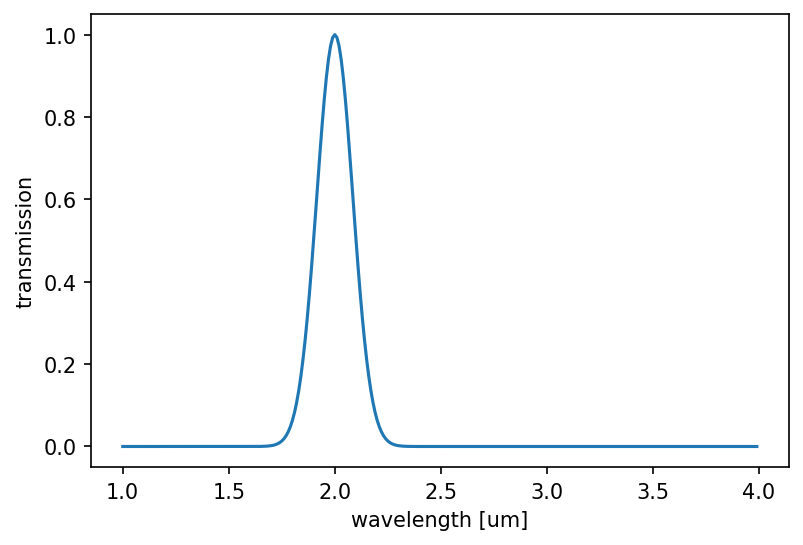

In [9]:
from astropy.modeling.models import Gaussian1D

prof = Gaussian1D(amplitude=1, mean=2, stddev=0.2/2.35)
x = np.arange(1, 4, .01)
plt.plot(x, prof(x))
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

### Top Hat Function Approximation for narrowband filters

In [10]:
def tophat_trans(x, center=0, fwhm=1, smoothness=0.2):

    from scipy.special import erf, erfc
    
    t_left  = erfc(+((2*(x-center)/fwhm)-1)/smoothness)/2 
    t_right = erfc(-((2*(x-center)/fwhm)+1)/smoothness)/2
    
    return (t_left*t_right)

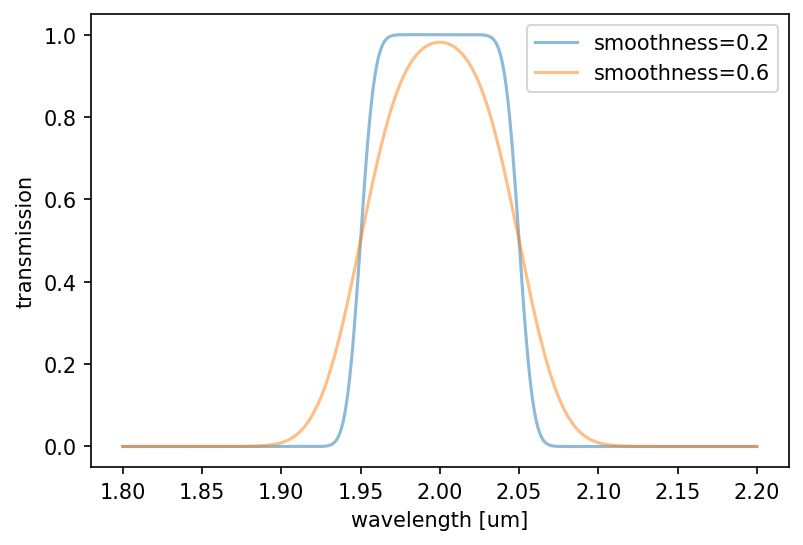

In [11]:
x = np.arange(1.8, 2.2, 0.001)
plt.plot(x, tophat_trans(x, center=2, fwhm=0.1, smoothness=0.2), '-', alpha=0.5, label='smoothness=0.2')
plt.plot(x, tophat_trans(x, center=2, fwhm=0.1, smoothness=0.6), '-', alpha=0.5, label='smoothness=0.6')
plt.legend()
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

## 2. LVF Design
- Figure for LVF parameters
- Q. generate transmission as a function of (x, y)?
  - We will approximate the transmission curve as a Gaussian
  - `wl_lvf, tr_lvf = get_lvf_trans(xpos, ypos, index=index)`

### LVF with a fixed $\Delta\lambda$

In [12]:
# Free parameters
R = 40        # Resolving power at each LVF point 
lmin = 1.00   # minimum wavelength [um]
dl = lmin / R # filter width [FWHM]
Nchan = 20    # Number of independent resolution elements with the LVF

ichan = np.arange(Nchan)
lcen = lmin + dl * ichan
width = np.zeros_like(ichan) + dl

In [13]:
ichan
lcen
width

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025])

In [18]:
# Different ways to print the data
for i, l, w in zip(ichan, lcen, width):
    print(f"{i:02d} {l:8.3f} {w:8.3f}")

T = Table([ichan, lcen], names=('ichan', 'lcen'))
print(T)

print(np.c_[ichan, lcen, width])

00    1.000    0.025
01    1.025    0.025
02    1.050    0.025
03    1.075    0.025
04    1.100    0.025
05    1.125    0.025
06    1.150    0.025
07    1.175    0.025
08    1.200    0.025
09    1.225    0.025
10    1.250    0.025
11    1.275    0.025
12    1.300    0.025
13    1.325    0.025
14    1.350    0.025
15    1.375    0.025
16    1.400    0.025
17    1.425    0.025
18    1.450    0.025
19    1.475    0.025
ichan  lcen
----- -----
    0   1.0
    1 1.025
    2  1.05
    3 1.075
    4   1.1
    5 1.125
    6  1.15
    7 1.175
    8   1.2
    9 1.225
   10  1.25
   11 1.275
   12   1.3
   13 1.325
   14  1.35
   15 1.375
   16   1.4
   17 1.425
   18  1.45
   19 1.475
[[ 0.     1.     0.025]
 [ 1.     1.025  0.025]
 [ 2.     1.05   0.025]
 [ 3.     1.075  0.025]
 [ 4.     1.1    0.025]
 [ 5.     1.125  0.025]
 [ 6.     1.15   0.025]
 [ 7.     1.175  0.025]
 [ 8.     1.2    0.025]
 [ 9.     1.225  0.025]
 [10.     1.25   0.025]
 [11.     1.275  0.025]
 [12.     1.3    0.025]
 [13

Text(0, 0.5, 'transmission')

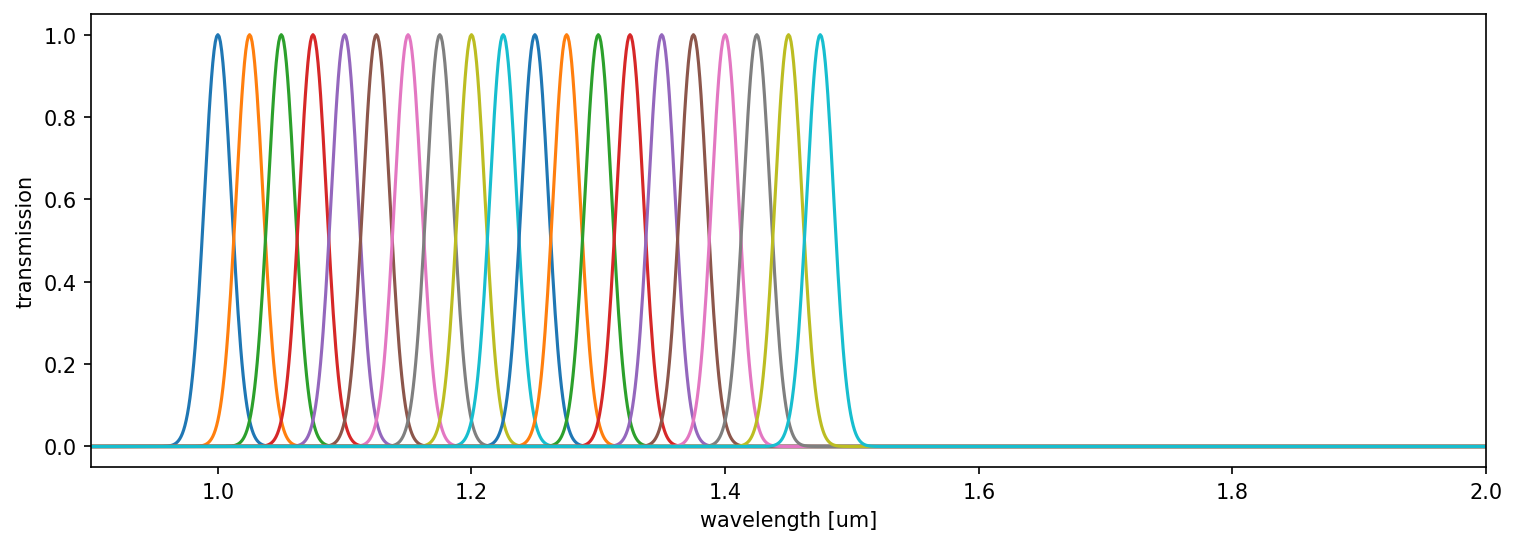

In [15]:
# Plot
wvec = np.linspace(0.5, 5.5, 5001)
plt.figure(figsize=(12,4))
for i, l, w in zip(ichan, lcen, width):
    prof = Gaussian1D(amplitude=1, mean=l, stddev=w/2.35)
    plt.plot(wvec, prof(wvec))

plt.xlim(0.9,2.0)
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

Text(0, 0.5, 'transmission')

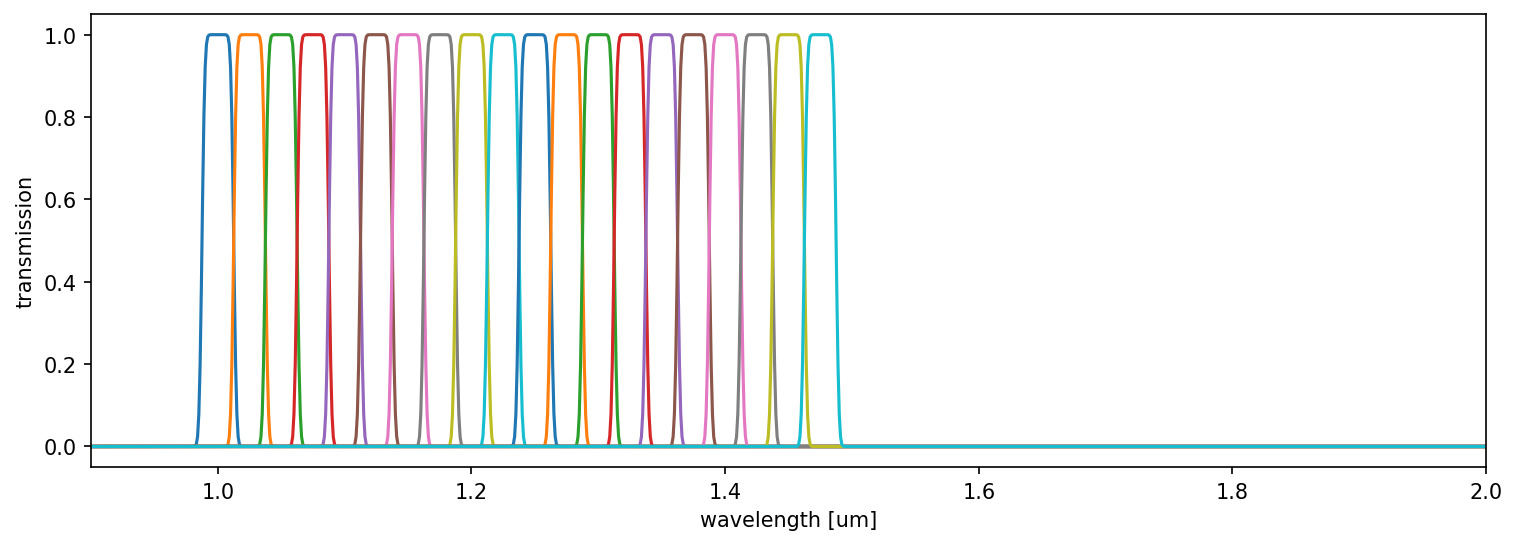

In [16]:
plt.figure(figsize=(12,4))
for i, l, w in zip(ichan, lcen, width):
    trans = tophat_trans(wvec, center=l, fwhm=w)
    plt.plot(wvec, trans)

plt.xlim(0.9,2.0)
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

In [17]:
# Spectral resolution
lcen / width
print(np.c_[ichan, lcen, lcen/width])

[[ 0.     1.    40.   ]
 [ 1.     1.025 41.   ]
 [ 2.     1.05  42.   ]
 [ 3.     1.075 43.   ]
 [ 4.     1.1   44.   ]
 [ 5.     1.125 45.   ]
 [ 6.     1.15  46.   ]
 [ 7.     1.175 47.   ]
 [ 8.     1.2   48.   ]
 [ 9.     1.225 49.   ]
 [10.     1.25  50.   ]
 [11.     1.275 51.   ]
 [12.     1.3   52.   ]
 [13.     1.325 53.   ]
 [14.     1.35  54.   ]
 [15.     1.375 55.   ]
 [16.     1.4   56.   ]
 [17.     1.425 57.   ]
 [18.     1.45  58.   ]
 [19.     1.475 59.   ]]


### LVF with a fixed resolving power ($R$)

In [20]:
# Free parameters
# lmin, lmax, Nchan --> R
lmin = 1.00  # minimum wavelength [um]
Nchan = 5    # Number of independent resolution elements with the LVF
R = 40       # Resolving power at each LVF point

ichan = np.arange(Nchan)
lcen  = lmin * ( (2*R+1)/(2*R-1) )**ichan  # Why?
width = lcen / R

lcen, width

(array([1.        , 1.02531646, 1.05127383, 1.07788836, 1.10517667]),
 array([0.025     , 0.02563291, 0.02628185, 0.02694721, 0.02762942]))

In [21]:
# Free parameters
# lmin, lmax, Nchan --> R
lmin = 1.00  # minimum wavelength [um]
Nchan = 20   # Number of independent resolution elements with the LVF
R = 40       # Resolving power at each LVF point 

ichan = np.arange(Nchan)
lcen = lmin * ( (2*R+1)/(2*R-1) )**ichan
width = lcen / R
Rvec = np.zeros_like(lcen) + R

print(np.c_[ichan, lcen, width])

[[ 0.          1.          0.025     ]
 [ 1.          1.02531646  0.02563291]
 [ 2.          1.05127383  0.02628185]
 [ 3.          1.07788836  0.02694721]
 [ 4.          1.10517667  0.02762942]
 [ 5.          1.13315583  0.0283289 ]
 [ 6.          1.16184332  0.02904608]
 [ 7.          1.19125708  0.02978143]
 [ 8.          1.22141548  0.03053539]
 [ 9.          1.25233739  0.03130843]
 [10.          1.28404214  0.03210105]
 [11.          1.31654953  0.03291374]
 [12.          1.3498799   0.033747  ]
 [13.          1.38405408  0.03460135]
 [14.          1.41909342  0.03547734]
 [15.          1.45501984  0.0363755 ]
 [16.          1.49185578  0.03729639]
 [17.          1.52962428  0.03824061]
 [18.          1.56834895  0.03920872]
 [19.          1.60805398  0.04020135]]


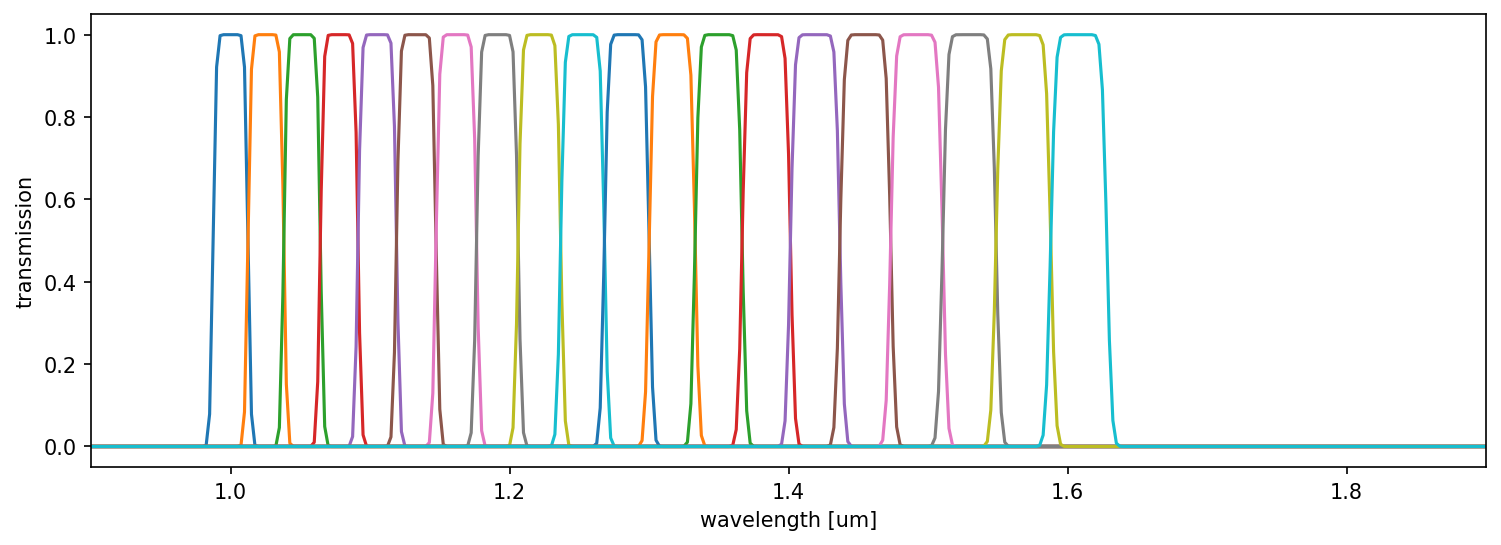

In [22]:
# Plot in linear space
wvec = np.linspace(0.5,5.5,2001)
plt.figure(figsize=(12,4))
for i, l, w in zip(ichan, lcen, width):
    # prof = Gaussian1D(amplitude=1, mean=l, stddev=w/2.35)
    # _ = plt.plot(wvec, prof(wvec))
    trans = tophat_trans(wvec, center=l, fwhm=w)
    plt.plot(wvec, trans)
    
plt.xlim(0.9,1.9)
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

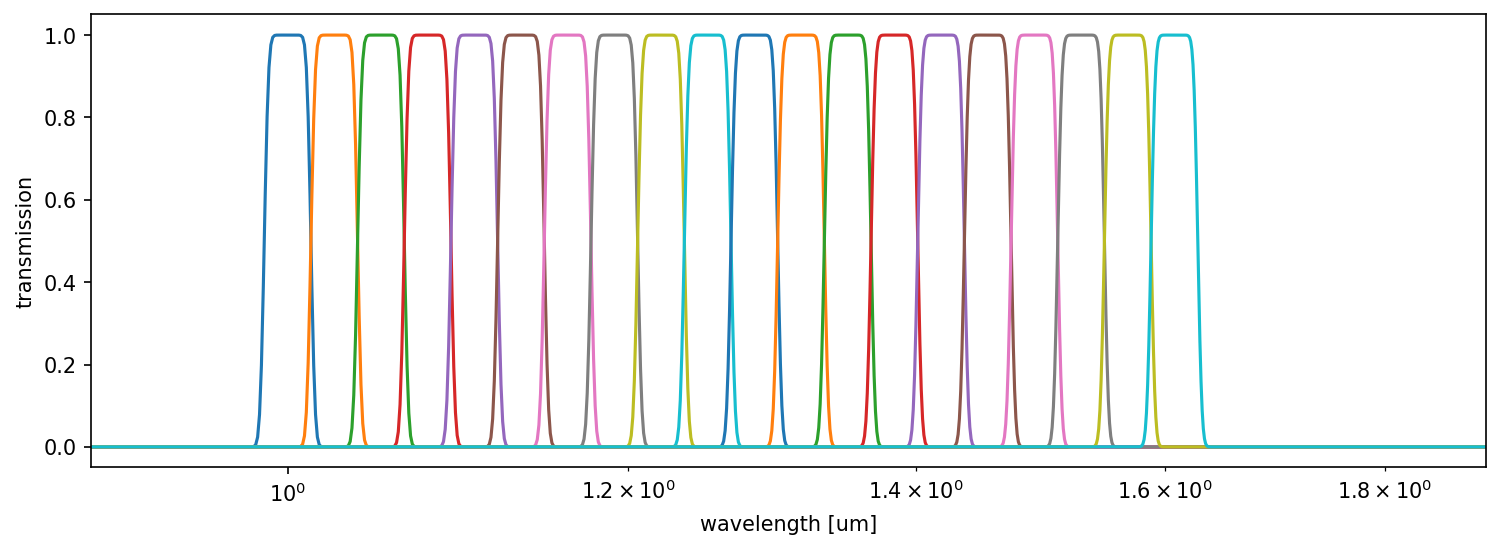

In [23]:
# Plot in log space
wvec = np.linspace(0.5,5.5,5001)
plt.figure(figsize=(12,4))
for i, l, w in zip(ichan, lcen, width):
    trans = tophat_trans(wvec, center=l, fwhm=w)
    plt.plot(wvec, trans)
    
plt.xlim(0.9,1.9)
plt.xscale('log')
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')

## 3. LVF Implementation

### Mapping from detector pixels to central wavelengths
- 2D LVF wavelength map: (xpos, ypos) to $\lambda_C$
- Now we have to implement the LVF specification into a physical LVF. (**Engineers' regime**)
- Close interaction between astronomers and engineers are essential (like NISS & SPHEREx mission)
- Pointing accuray: spacing that we can sample
- 1D first, map ypos (in pixels) to lambda_C

In [24]:
nx, ny = 1024, 2048

# place 0.5 channel at the beginning and end of the detector
ypos = (ny / Nchan) * (ichan+0.5)

(ny / Nchan) * (-0.5        + 0.5)   # edge: channel = -0.5  
(ny / Nchan) * (Nchan-1+0.5 + 0.5)   # edge: channel = Nchan-1 + 0.5

2048.0

Text(0, 0.5, 'Central Wavelength [um]')

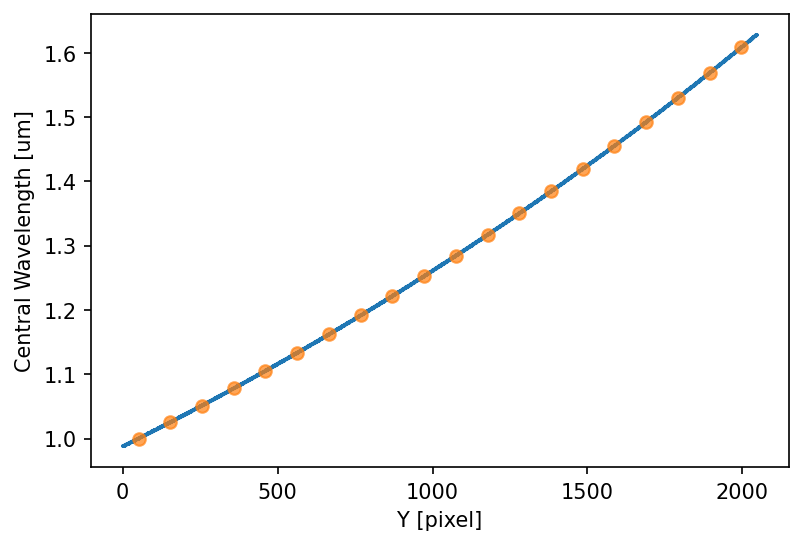

In [30]:
def get_ichan(ypix):
    """
    Returns channel number for detector ypix
    """
    nx, ny = 1024, 2048
    return Nchan / ny * ypix - 0.5

lcen = lmin * ( (2*R+1)/(2*R-1) )**ichan

yvec = np.arange(2048)
plt.plot(yvec, lmin * ( (2*R+1)/(2*R-1) )**get_ichan(yvec), '+', ms=2)
plt.plot(ypos, lcen, 'o', alpha=0.7)
plt.xlabel('Y [pixel]')
plt.ylabel('Central Wavelength [um]')

### Telescope focal length & plate scale
 - plate scale [arcsec/mm] = $\frac{206265}{f [mm]}$
     - f = effective focal length
 - convert to pixel scale
     - pixscale = plate scale * detector pixel size
 - FOV: determined by optical performance, in this case, determined by the field stop (i.e., detector size)

- SPHEREx six H2RG (Hawaii-2RG infrared detectors)
    - Short wavelength: 2.6um cutoff
    - Long wavelength: 5.3um cutoff
    - 2048 x 2048 array, 18um x 18um pixels, HgCdTe technology

In [31]:
# SPHEREx F-number = 3
print(206265 / (200*3) * 18e-3                  ) # pixel scale [arcsec]
print(206265 / (200*3) * 18e-3 * 2048 / 60 / 60 ) # FOV [deg]

6.187949999999999
3.5202559999999994


### Make a LVF map & display

In [44]:
xv = np.arange(nx)
yv = np.arange(ny)

xx, yy = np.meshgrid(xv, yv, indexing='xy')

wavemap = lmin * ( (2*R+1)/(2*R-1) )**get_ichan(yy)

print(f"{wavemap.shape = }\n{xv.shape = }\n{xx.shape = }")

wavemap.shape = (2048, 1024)
xv.shape = (1024,)
xx.shape = (2048, 1024)


Text(0.5, 1.0, 'X')

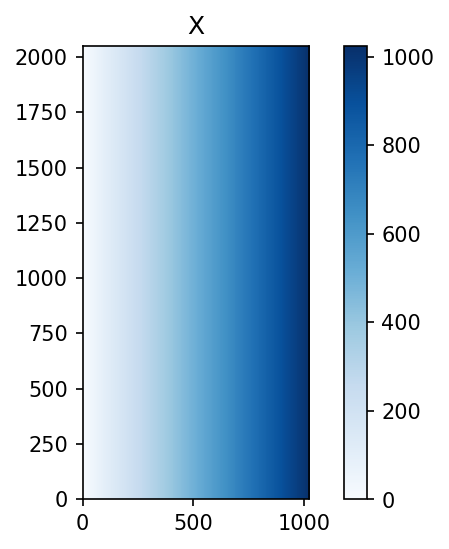

In [33]:
plt.imshow(xx, origin='lower', cmap='Blues')
plt.colorbar()
plt.title('X')

Text(0.5, 1.0, 'Y')

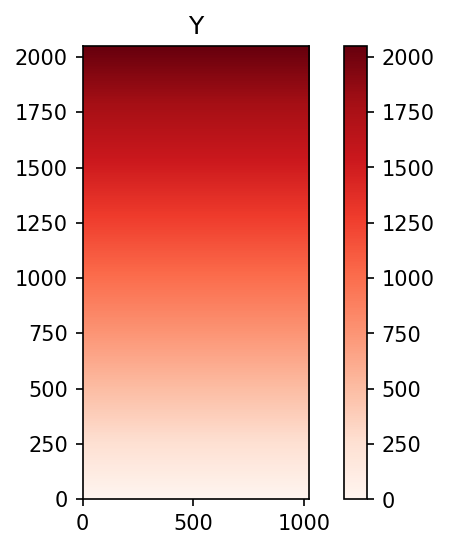

In [34]:
plt.imshow(yy, origin='lower', cmap='Reds')
plt.colorbar()
plt.title('Y')

Text(0.5, 1.0, 'Wavelenth [$\\mu$m]')

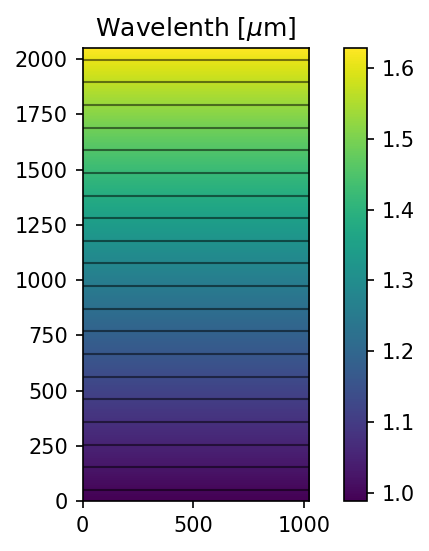

In [35]:
plt.imshow(wavemap, origin='lower')
plt.colorbar()
plt.contour(wavemap, lcen, colors='k', linewidths=1, alpha=0.5)
plt.title('Wavelenth [$\mu$m]')

### Generate `get_lvf_trans()` function
- Write a Python function to get LVF transmission for a given detector position (xpos, ypos)
- `wl_lvf, tr_lvf = get_lvf_trans(x, y, band=1)`

In [36]:
def get_lvf_trans(x, y, band=1):
    # `band` not used at the moments

    # Get R (hard-coded for now)
    # TODO: R should be determined from the band
    R = 40
    lmin = 1.0

    # get the central wavelenth
    wcen = lmin * ( (2*R+1)/(2*R-1) )**get_ichan(y)
    fwhm = wcen / R
    
    prof = Gaussian1D(amplitude=1, mean=wcen, stddev=fwhm/2.35)
    
    # wavelenth vector
    wl_lvf = np.linspace(wcen-fwhm*3, wcen+fwhm*3, 200)
    tr_lvf = prof(wl_lvf)
    
    return wl_lvf, tr_lvf

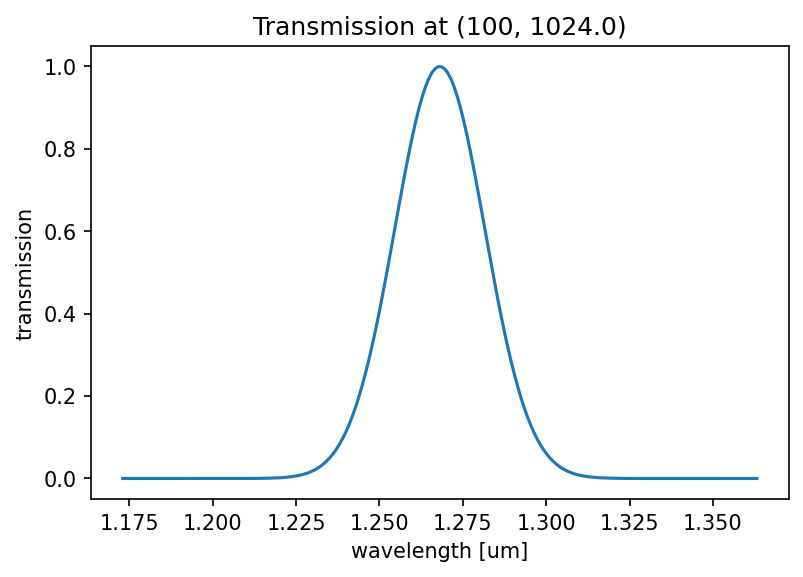

In [37]:
xpos, ypos = 100, 2048/2
wl_lvf, tr_lvf = get_lvf_trans(xpos, ypos)
plt.plot(wl_lvf, tr_lvf)
plt.xlabel('wavelength [um]')
plt.ylabel('transmission')
plt.title(f'Transmission at ({xpos}, {ypos})')

### Advanced: Smile Pattern
In reallity, it is not possible to apply coating exactly parallel to one of the axes. There will be small curvatures in LVF coatings, the so-called **smile pattern**. Let's simulate this patteren in an ad-hoc manner.

Text(0.5, 1.0, 'Y')

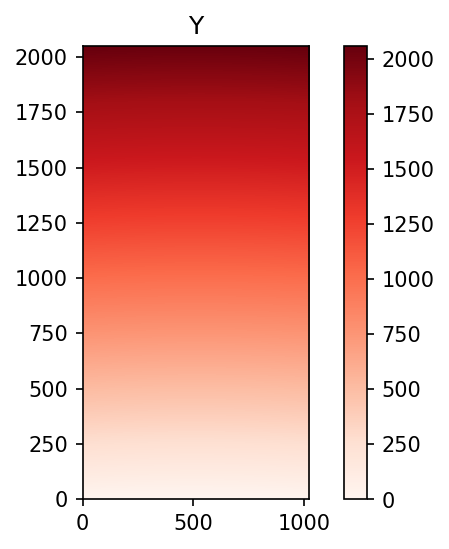

In [38]:
x0 = nx/2
y0 = -10000
r2 = (xx-x0)**2 + (yy-y0)**2
yy_eff = np.sqrt(r2) + y0

plt.imshow(yy_eff, origin='lower', cmap='Reds')
plt.colorbar()
plt.title('Y')

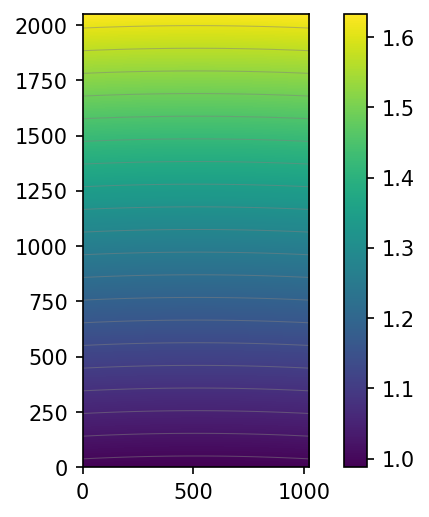

In [39]:
wavemap_smile = lmin * ( (2*R+1)/(2*R-1) )**get_ichan(yy_eff)
plt.imshow(wavemap_smile, origin='lower')
plt.colorbar()
levels = lcen
plt.contour(wavemap_smile, levels, colors='gray', linewidths=0.5, alpha=0.5)

# <span style='color:DarkSlateBlue'> Exercises </span>


## Exercise 1.1
- How many resolution elements (channels) do we need to cover from 0.75um to 5.0um with a constant R = 40?
- How many LVFs are required if each LVF can house 15 channels?

## Exercise 1.2
- For a given lmin = 1.0, lmax = 2.0, R = 100, how many independent channels can this LVF have?

## Exercise 1.3
- How many pointings does it take to cover the all sky?
- Assume a FOV = 3.5 degree

## Excercise 1.4 (SPHEREx) - advanced
- Repeat the above analysis for the current SPHEREx LVF design. Build the six SPHEREx LVF wavelength maps. You can ignore the `smiles`.

## Excercise 1.5 (Python)  - advanced
- update get_lvf_trans() function to have a profile function also as an argument
- `wl_lvf, tr_lvf = get_lvf_trans(x, y, profile='gaussian', band=1)`
- In fact, the `tophat_trans` function is broken or is destined to fail in a certain regime. Can you find it?

## Excercise 1.6 (7DT/7DS)
- Plot 7DT/7DS filter transmission curves
  - 40 medium band filters: $\Delta \lambda$ = 200A, $\lambda_{min}$ = 4,000, $\lambda_{max}$ = 8,000
- Re-design 7DS filter system so that the bandpass has a constant resolving power ($R$) instead

## Excercise 1.7 (7DT/7DS)
- Assume that we like to carry out the 7DS using LVF filters instead of 40 filters and 20 telescopes. How many spectral channels would be required if a single LVF will be used? Design this LVF wavelength map.